In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

# load the data
data_path = 'data/aggregate_data.csv'
data = pd.read_csv(data_path)

# show the first few rows and the columns
data.head(), data.columns

(         time       id  start_date    end_date  activity  circumplex.arousal  \
 0  2014-03-26  AS14.01  2014-03-19  2014-03-26  0.108532            0.033333   
 1  2014-03-27  AS14.01  2014-03-20  2014-03-27  0.134520            0.066667   
 2  2014-03-29  AS14.01  2014-03-22  2014-03-29  0.109674            0.066667   
 3  2014-03-30  AS14.01  2014-03-23  2014-03-30  0.092269           -0.033333   
 4  2014-03-31  AS14.01  2014-03-24  2014-03-31  0.062600           -0.100000   
 
    circumplex.valence        screen  appCat.builtin  appCat.communication  \
 0            0.655556   8491.192334      900.907333           5464.767000   
 1            0.733333  13546.594334     1227.690000           7054.194667   
 2            0.800000  14062.857666     1449.818000           6215.319000   
 3            0.850000  10095.995333     1198.774000           3651.903000   
 4            0.783333   8227.556667     1776.133333           3117.278000   
 
    appCat.main  appCat.tools  appCat.cont

In [3]:
from business_calendar import Calendar, MO, TU, WE, TH, FR
cal = Calendar(workdays=[MO,TU,WE,TH,FR])

In [4]:
def is_working_day(date):
    if cal.isbusday(date):
        return True
    else:
        return False

In [5]:
data['is_working_day'] = data['time'].map(is_working_day) # add a feature :  if a date is working day

In [6]:
data.columns

Index(['time', 'id', 'start_date', 'end_date', 'activity',
       'circumplex.arousal', 'circumplex.valence', 'screen', 'appCat.builtin',
       'appCat.communication', 'appCat.main', 'appCat.tools', 'appCat.contact',
       'mood', 'mood_label', 'is_working_day'],
      dtype='object')

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

In [8]:
X = data[["activity", "circumplex.arousal", "circumplex.valence", "screen", "appCat.builtin",
         "appCat.communication", "appCat.main", "appCat.tools", "appCat.contact", "mood", "is_working_day"]]
y = data["mood_label"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [25]:
#below is ridge regression
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the Ridge Regression model
ridge = Ridge(alpha=1.0)  # Adjust the regularization strength (alpha)
ridge.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = ridge.predict(X_test_scaled)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
#Calculate mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

Mean Squared Error: 0.46222111459391196
Mean Absolute Error: 0.4956441703616388


In [20]:
#below is xgboost
# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # Regression task
    'colsample_bytree': 0.8,           # Subsample ratio of columns
    'learning_rate': 0.1,              # Step size shrinkage used in update to prevent overfitting
    'max_depth': 5,                    # Maximum depth of a tree
    'alpha': 10,                       # L1 regularization term on weights
    'lambda': 1                        # L2 regularization term on weights
}

# Train the XGBoost model
num_round = 100  # Number of boosting rounds
bst = xgb.train(params, dtrain, num_round)

# Make predictions on the test set
y_pred2 = bst.predict(dtest)

# Calculate Mean Squared Error and Mean Absolute Error
mse2 = mean_squared_error(y_test, y_pred2)
print("Mean Squared Error:", mse2)
mae2 = mean_absolute_error(y_test, y_pred2)
print("Mean Absolute Error:", mae2)

Mean Squared Error: 0.4694539489080769
Mean Absolute Error: 0.4963770742001741


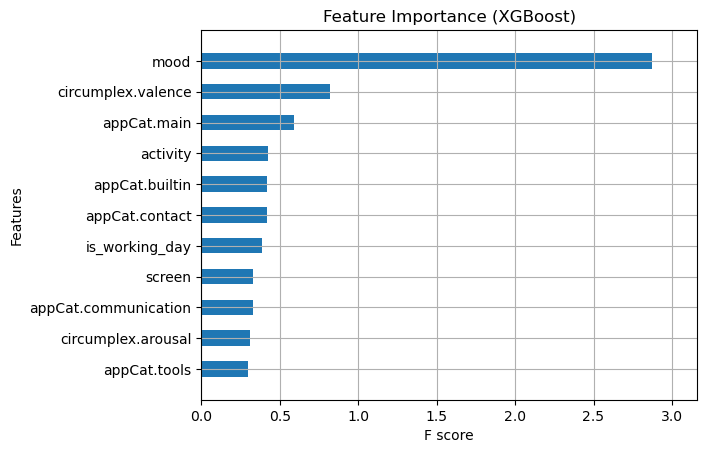

In [17]:
xgb.plot_importance(bst, height=0.5, title="Feature Importance (XGBoost)", importance_type="gain", show_values=False)
plt.show()

In [14]:
from sklearn.metrics import classification_report
y_pred_classes = np.round(y_pred)
print(classification_report(y_pred_classes, y_test))

              precision    recall  f1-score   support

         4.0       0.00      0.00      0.00         0
         5.0       0.00      0.00      0.00         0
         6.0       0.26      0.67      0.38        15
         7.0       0.94      0.59      0.72       160
         8.0       0.15      0.67      0.24         9
         9.0       0.00      0.00      0.00         0

    accuracy                           0.60       184
   macro avg       0.22      0.32      0.22       184
weighted avg       0.85      0.60      0.67       184



d:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
y_pred_classes2 = np.round(y_pred)
print(classification_report(y_pred_classes2, y_test))

              precision    recall  f1-score   support

         4.0       0.00      0.00      0.00         0
         5.0       0.00      0.00      0.00         0
         6.0       0.26      0.67      0.38        15
         7.0       0.94      0.59      0.72       160
         8.0       0.15      0.67      0.24         9
         9.0       0.00      0.00      0.00         0

    accuracy                           0.60       184
   macro avg       0.22      0.32      0.22       184
weighted avg       0.85      0.60      0.67       184



d:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
